## Vegitation Density and its relationship with Income of residents in the Greater Vancouver area


In [3]:
import os
os.environ['GDAL_DATA'] = 'C:/Users/86sky/anaconda3/envs/myenv/Library/share/gdal'
os.environ['PROJ_LIB'] = 'C:/Users/86sky/anaconda3/envs/myenv/Library/share/proj'


In [3]:
import rasterio
from rasterio.plot import show
import numpy as np
import matplotlib.pyplot as plt

path_to_B08_1 = "Documents/Data/S2B_MSIL2A_20230709T190919_N0509_R056_T10UDV_20230709T214636.SAFE/GRANULE/L2A_T10UDV_A033115_20230709T191942/IMG_DATA/R10m/T10UDV_20230709T190919_B08_10m.jp2"
path_to_B04_1 = "Documents/Data/S2B_MSIL2A_20230709T190919_N0509_R056_T10UDV_20230709T214636.SAFE/GRANULE/L2A_T10UDV_A033115_20230709T191942/IMG_DATA/R10m/T10UDV_20230709T190919_B04_10m.jp2"
path_to_B04_2 = "Documents/Data/S2B_MSIL2A_20230709T190919_N0509_R056_T10UEV_20230709T214636.SAFE/GRANULE/L2A_T10UEV_A033115_20230709T191942/IMG_DATA/R10m/T10UEV_20230709T190919_B04_10m.jp2"
path_to_B08_2 = "Documents/Data/S2B_MSIL2A_20230709T190919_N0509_R056_T10UEV_20230709T214636.SAFE/GRANULE/L2A_T10UEV_A033115_20230709T191942/IMG_DATA/R10m/T10UEV_20230709T190919_B08_10m.jp2"


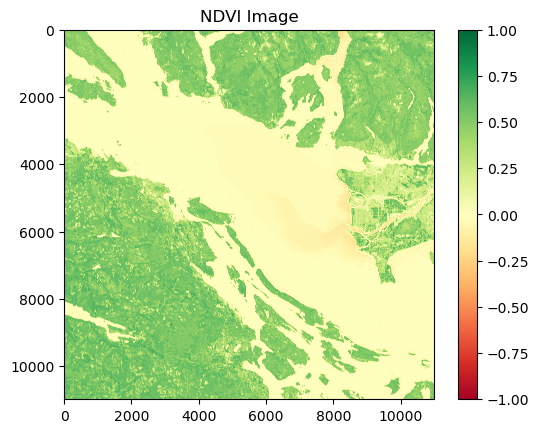

In [4]:
# Open the red and NIR bands
with rasterio.open(path_to_B04_1) as red_band, \
     rasterio.open(path_to_B08_1) as nir_band:

    # Read the bands as arrays
    red = red_band.read(1).astype('float64')
    nir = nir_band.read(1).astype('float64')
    
    # Calculate NDVI
    ndvi = (nir - red) / (nir + red)
    
    # Handle division by zero
    ndvi[np.isnan(ndvi)] = 0

# Save NDVI image
with rasterio.open(
    'NDVI_1.tif',
    'w',
    driver='GTiff',
    width=red_band.width,
    height=red_band.height,
    count=1,
    crs=red_band.crs,
    transform=red_band.transform,
    dtype='float64'
    ) as dst:
    dst.write(ndvi, 1)

# Display the NDVI image
plt.imshow(ndvi, cmap='RdYlGn')
plt.colorbar()
plt.title('NDVI Image')
plt.show()

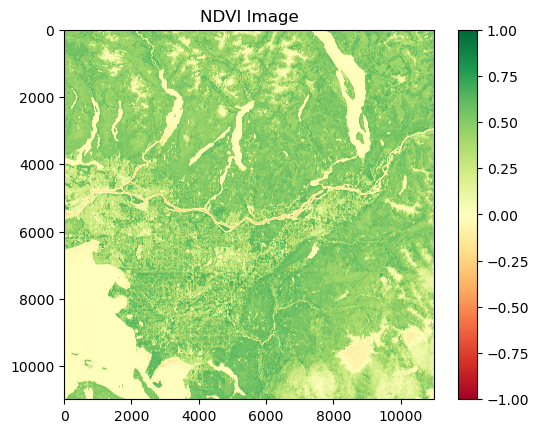

In [5]:
# Open the red and NIR bands
with rasterio.open(path_to_B04_2) as red_band, \
     rasterio.open(path_to_B08_2) as nir_band:

    # Read the bands as arrays
    red = red_band.read(1).astype('float64')
    nir = nir_band.read(1).astype('float64')
    
    # Calculate NDVI
    ndvi = (nir - red) / (nir + red)
    
    # Handle division by zero
    ndvi[np.isnan(ndvi)] = 0

# Save NDVI image
with rasterio.open(
    'NDVI_2.tif',
    'w',
    driver='GTiff',
    width=red_band.width,
    height=red_band.height,
    count=1,
    crs=red_band.crs,
    transform=red_band.transform,
    dtype='float64'
    ) as dst:
    dst.write(ndvi, 1)

# Display the NDVI image
plt.imshow(ndvi, cmap='RdYlGn')
plt.colorbar()
plt.title('NDVI Image')
plt.show()

In [6]:
from osgeo import gdal

# Specify the names of the input .jp2 files and the output file
input_files = ['NDVI_1.tif', 'NDVI_2.tif']
output_file = 'stitched_NDVI.tif'

# Use GDAL's Warp function to merge the files
# This function also reprojects the images if they are in different projections
gdal.Warp(output_file, input_files)
# Check if the file is created successfully
print(f'Merged file created: {output_file}')

Merged file created: stitched_NDVI.tif


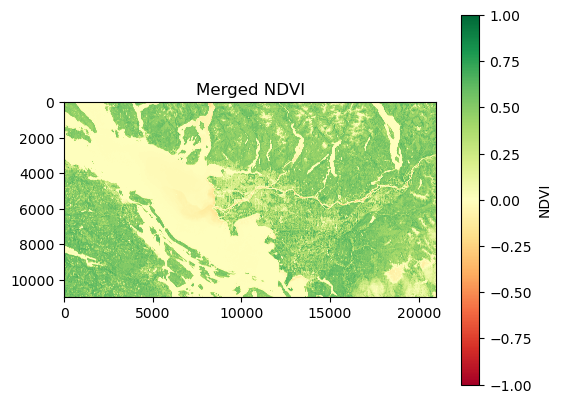

In [7]:
# Open the merged file
with rasterio.open(output_file) as src:
    # Read the data
    ndvi = src.read(1)  # Read the first band into memory
    meta = src.meta
    
    # Plot the data
    plt.imshow(ndvi, cmap='RdYlGn')
    plt.colorbar(label='NDVI', fraction=0.2)
    plt.title('Merged NDVI')
    plt.show()

In [1]:
import geopandas as gpd

# path to your multipolygon file
multipolygon_path = 'Documents/Data/geospatial/lct_000b21a_e/lct_000b21a_e.shp'
multipolygon = gpd.read_file(multipolygon_path)


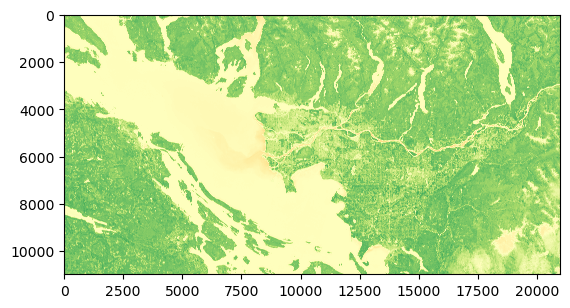

<Axes: >

In [4]:
ndvi_raster_path = 'stitched_NDVI.tif'
with rasterio.open(ndvi_raster_path) as src:
    ndvi = src.read(1)  # Read the first band into memory
    meta = src.meta
    
show(ndvi, cmap='RdYlGn')  # Optional: visualize the NDVI raster

In [5]:
# Assuming 'nodata_value' is defined (e.g., src.nodata or a specific value like -9999)
# If nodata values are NaNs
valid_ndvi_values = ndvi[0][~np.isnan(ndvi[0])].flatten()

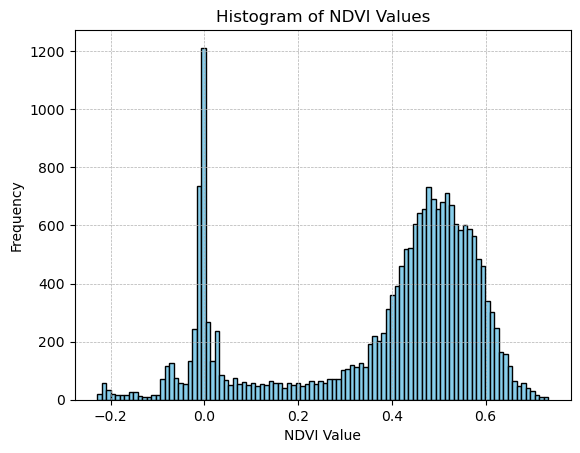

In [6]:
# Plot histogram of NDVI values
plt.hist(valid_ndvi_values, bins=100, color='skyblue', edgecolor='black')
plt.title('Histogram of NDVI Values')
plt.xlabel('NDVI Value')
plt.ylabel('Frequency')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [7]:
from rasterio.crs import CRS

correct_crs = CRS.from_epsg(32610)

# Open the raster file and write the CRS
with rasterio.open(ndvi_raster_path, 'r+') as src:
    src.crs = correct_crs
    print(f"Assigned CRS {correct_crs} to {ndvi_raster_path}")
    
# Load the GeoJSON
print("GeoJSON CRS:", multipolygon.crs)

Assigned CRS EPSG:32610 to stitched_NDVI.tif
GeoJSON CRS: epsg:32610


In [8]:
from rasterio.mask import mask

with rasterio.open(ndvi_raster_path) as src:
    out_image, out_transform = mask(src, multipolygon.geometry, crop=True, nodata=np.nan, all_touched=True)
    out_meta = src.meta.copy()

out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
with rasterio.open('masked_stitched_NDVI.tif', 'w', **out_meta) as dest:
    dest.write(out_image)


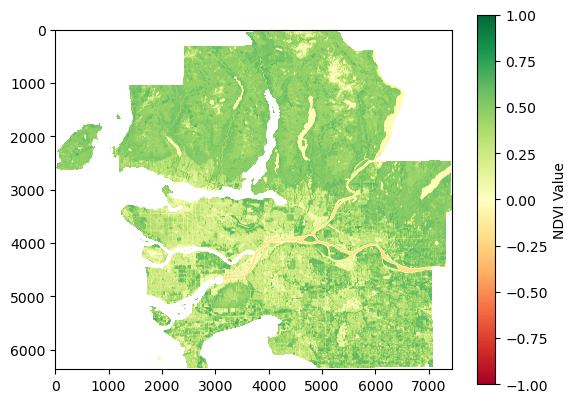

In [9]:
# Assuming out_image is your masked raster data
data = out_image.copy()

# Create a masked array where NaN values are masked
masked_data = np.ma.array(data, mask=np.isnan(data))

# Plot
fig, ax = plt.subplots()
# Choosing 'viridis' but setting background as 'white' for NaN values
cmap = plt.cm.RdYlGn
cmap.set_bad('white', 1.)
im = ax.imshow(masked_data[0], cmap=cmap)

# Add colorbar
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('NDVI Value')
plt.show()

In [10]:
# Assuming 'nodata_value' is defined (e.g., src.nodata or a specific value like -9999)
# If nodata values are NaNs
valid_ndvi_values = out_image[0][~np.isnan(out_image[0])].flatten()

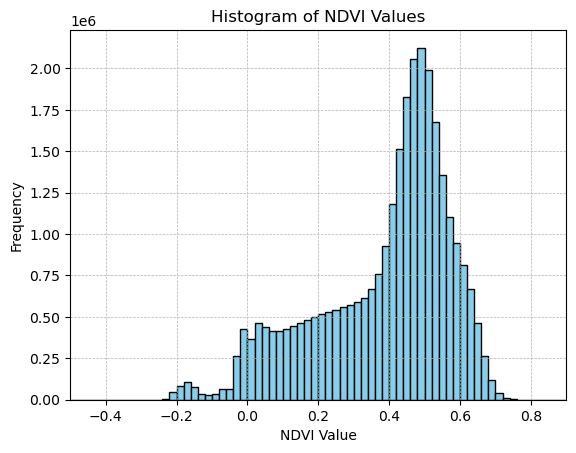

In [11]:
# Plot histogram of NDVI values
plt.hist(valid_ndvi_values, bins=100, color='skyblue', edgecolor='black')
plt.title('Histogram of NDVI Values')
plt.xlabel('NDVI Value')
plt.ylabel('Frequency')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
# Adjust the x-axis to better fit the data's range
plt.xlim(-0.5, 0.90)
plt.show()

In [12]:
from rasterstats import zonal_stats

In [13]:
# Load the census tracts shapefile
tracts_gdf = gpd.read_file('Documents/Data/geospatial/census-tracts-minus-northern-quadrant/lct_000b21a_e.shp')

# Assuming the NDVI raster is already loaded or accessible as `stitched_ndvi_path`
ndvi_raster_path = 'masked_stitched_NDVI.tif'

In [14]:
print(tracts_gdf.crs)
with rasterio.open(ndvi_raster_path) as src:
     raster_crs = src.crs
print(raster_crs)

epsg:32610
EPSG:32610


In [15]:
with rasterio.open(ndvi_raster_path) as ndvi_src:
    nodata_value = ndvi_src.nodata
    if nodata_value is None:
        # Set a default nodata value if it's not defined in the raster
        nodata_value = -999
    stats = zonal_stats(tracts_gdf, ndvi_raster_path, stats=['mean', 'median', 'max', 'min'], nodata=nodata_value, all_touched=True, geojson_out=True)

# Convert the stats back to a GeoDataFrame
stats_gdf = gpd.GeoDataFrame.from_features(stats)


In [16]:
# Print the first few rows to inspect
print(stats_gdf.head())

# Save to a new shapefile (optional)
stats_gdf.to_file('census_tracts_ndvi_stats.shp')


                                            geometry       CTUID  \
0  POLYGON ((517784.918 5444029.856, 517771.924 5...  9330187.11   
1  POLYGON ((539442.486 5452055.315, 539440.940 5...  9330400.04   
2  POLYGON ((494620.024 5462154.701, 494401.611 5...  9330101.03   
3  POLYGON ((494963.134 5462794.235, 494726.493 5...  9330101.04   
4  POLYGON ((495677.315 5451936.945, 495627.975 5...  9330014.01   

                 DGUID   CTNAME  LANDAREA PRUID       min       max      mean  \
0  2021S05079330187.11  0187.11    1.3857    59 -0.044376  0.702824  0.247504   
1  2021S05079330400.04  0400.04   12.4035    59 -0.219267  0.738701  0.454391   
2  2021S05079330101.03  0101.03    0.3386    59 -0.021426  0.627239  0.227871   
3  2021S05079330101.04  0101.04    0.3021    59 -0.036458  0.573150  0.136340   
4  2021S05079330014.01  0014.01    0.5041    59 -0.029078  0.628227  0.206372   

     median  
0  0.208262  
1  0.517117  
2  0.196133  
3  0.100038  
4  0.176717  


In [17]:
print(tracts_gdf.head())


        CTUID                DGUID   CTNAME  LANDAREA PRUID  \
0  9330187.11  2021S05079330187.11  0187.11    1.3857    59   
1  9330400.04  2021S05079330400.04  0400.04   12.4035    59   
2  9330101.03  2021S05079330101.03  0101.03    0.3386    59   
3  9330101.04  2021S05079330101.04  0101.04    0.3021    59   
4  9330014.01  2021S05079330014.01  0014.01    0.5041    59   

                                            geometry  
0  POLYGON ((517784.918 5444029.856, 517771.924 5...  
1  POLYGON ((539442.486 5452055.315, 539440.940 5...  
2  POLYGON ((494620.024 5462154.701, 494401.611 5...  
3  POLYGON ((494963.134 5462794.235, 494726.493 5...  
4  POLYGON ((495677.315 5451936.945, 495627.975 5...  


In [18]:
# Merge tracts_gdf with stats_gdf based on unique_id
merged_gdf = tracts_gdf.merge(stats_gdf[['DGUID', 'mean', 'max', 'min', 'median']], on='DGUID')

# Now, merged_gdf contains tract geometries along with their corresponding NDVI stats


In [19]:
print(merged_gdf.head())

        CTUID                DGUID   CTNAME  LANDAREA PRUID  \
0  9330187.11  2021S05079330187.11  0187.11    1.3857    59   
1  9330400.04  2021S05079330400.04  0400.04   12.4035    59   
2  9330101.03  2021S05079330101.03  0101.03    0.3386    59   
3  9330101.04  2021S05079330101.04  0101.04    0.3021    59   
4  9330014.01  2021S05079330014.01  0014.01    0.5041    59   

                                            geometry      mean       max  \
0  POLYGON ((517784.918 5444029.856, 517771.924 5...  0.247504  0.702824   
1  POLYGON ((539442.486 5452055.315, 539440.940 5...  0.454391  0.738701   
2  POLYGON ((494620.024 5462154.701, 494401.611 5...  0.227871  0.627239   
3  POLYGON ((494963.134 5462794.235, 494726.493 5...  0.136340  0.573150   
4  POLYGON ((495677.315 5451936.945, 495627.975 5...  0.206372  0.628227   

        min    median  
0 -0.044376  0.208262  
1 -0.219267  0.517117  
2 -0.021426  0.196133  
3 -0.036458  0.100038  
4 -0.029078  0.176717  
